# Libraryes 
Download all the library needed to execution of the notebook

In [134]:
import pandas as pd
import numpy as np
from Bio.SVDSuperimposer import SVDSuperimposer
from Bio.PDB.PDBParser import PDBParser
import matplotlib.pyplot as plt
import os
from Bio.PDB import PDBList, calc_angle, calc_dihedral, PPBuilder, is_aa, PDBIO, NeighborSearch,Selection
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import IUPACData
from Bio.PDB.PDBIO import Select
from Bio.SeqIO.PdbIO import PdbSeqresIterator
import numpy as np
import math
import matplotlib
import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt
from RamachanDraw import phi_psi
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import copy
from Bio.SeqUtils import seq1

# Protein download form PDB
This is the protein to analyze '2lea_A' download the assigned PDB structure and consider only standard (non-hetero) residues of the specified chain (<PDB ID>_<chain ID>). 

Calculate the contact map (question 1) and the conformational energy (questions 2 and 3) as described in the IUPRED paper. 

The M and P matrices are available from the iupred_data.py. The smoothed energy is the moving average of the raw energy over a window of 21 residues (±10 residues around the current position).

In [135]:
path = "./home/Documents/Structural-Bioinformatics"
id_protein, chain = ['2k0e', 'A' ]
parser = PDBParser(QUIET=True)
# if the file does not exist, it will be downloaded
if os.path.exists(path + "/pdb/pdb{}.ent".format(id_protein.lower())) is True:
  path_pdb = path + "/pdb/pdb{}.ent".format(id_protein.lower())
else:
  pdbl = PDBList()
  path_pdb = pdbl.retrieve_pdb_file(id_protein, pdir=path + "/pdb", file_format="pdb")
structure = parser.get_structure(id_protein, path_pdb)
new_structure = structure.copy()

if os.path.exists(path +'/figures_mid_term2') is False:
  os.mkdir(path +'/figures_mid_term2') 

# Define main function to use

In [136]:
def get_distance_matrix(atoms, seq_sep=6):
  """
  Calculate a distance matrix considering only 
  CA atoms and a minimum sequence separation.  
  Return a Numpy array
  """
  distances = []
  for atom1 in atoms:
    row = []
    for atom2 in atoms:
      # Check sequence separation
      # if abs(atom1.id[1] - atom2.id[1]) >= seq_sep:
      if abs(atoms.index(atom1) - atoms.index(atom2)) >= seq_sep:
        row.append(atom1 - atom2)
      else:
        row.append(None) # For atoms not respecting sequence separation
    distances.append(row)
  return np.array(distances, dtype=float)

In [137]:
def get_contact_map(atoms,len_residues, threshold=3.5, seq_sep=2):

  # Calculate contacts
  ns = NeighborSearch(atoms)

  len_residues=len_residues+1
  # Init a empty matrix
  contact_map_nb = np.zeros((len_residues, len_residues))

  # "search_all" returns the list of atoms in contact based on a distance cutoff
  # level="R" returns pairs of residues instead of atoms
  for residues1, residues2 in ns.search_all(threshold, 'R'):
    if abs(residues1.id[1] - residues2.id[1]) >= seq_sep:
          contact_map_nb[residues1.id[1] , residues2.id[1]] = 1
          contact_map_nb[residues2.id[1], residues1.id[1]] = 1
  return contact_map_nb

#### Load the structure

In [138]:
pdbl = PDBList()
pdbl.retrieve_pdb_file(id_protein, pdir=path + '/pdbs', file_format='pdb')
structure = PDBParser(QUIET=True).get_structure(id_protein, path + "/pdbs/pdb{}.ent".format(id_protein))

#### Select the atoms

In [139]:
selected_atoms = [atom for residue in structure[0][chain] if residue.id[0] == " " for atom in residue]

# 1. Contacts calculated with Neighbours Search

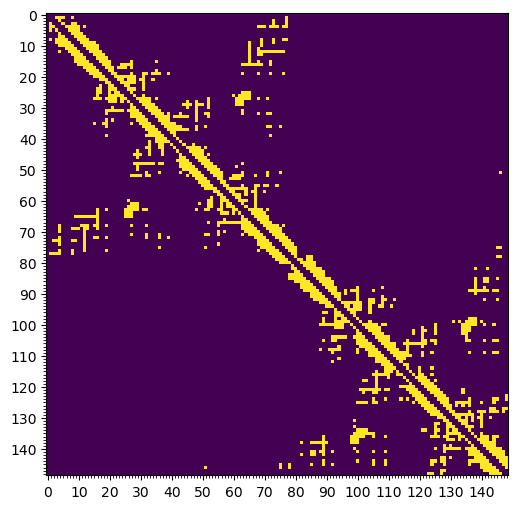

In [140]:

contact_map_nb = get_contact_map(selected_atoms, len([residue for residue in structure[0][chain] if residue.id[0]==" "]), threshold=6, seq_sep=2)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(contact_map_nb)

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.savefig(path + '/figures_mid_term2/ca_contacts_nb{}.png'.format(id_protein), dpi=300, bbox_inches='tight')

#2 . Exact Energy
> Calculate the exact energy of each residue based on the weighted contribution of its contacts
(as calculated above) and plot the raw and smoothed energy for each residue on the same figure.
Use the $M$ matrix to calculate the contact energy

 [Iupred_paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5734386/)

 Then, the energy of each residue is calculated by considering the number and types of the contacting amino acids and summing the appropriate elements of the statistical potential matrix.
$$E^{p}_i=∑^{20}_{j=1}M_{ij}c^{p}_j$$

where $E^{p}_i$ energy at position $p$ of type $i$, $M_{ij}$ is the interaction energy between amino acid types $i$ and $j$, and $c^{p}_j$ is the number of interactions of residue at position p with residues of type $j$ in the given conformation. Variations in these energies arise depending on the type and number of contacting residues, with hydrophobic residues buried inside the protein core generally exhibiting more favorable energies.

To eliminate the need to know the precise arrangements of residues in the structure, an energy estimation method was developed that can be used to approximate the energies directly from the amino acid sequence. For this, a crude approximation was introduced assuming that energy of a given residue mostly depends on its own type and the types of the amino acids that surround it. The key component of the calculations is the energy estimation matrix, a 20 × 20 matrix that connects the elements of the amino acid composition vector to the energy of a given residue. The energy of a given residues can be obtained by multiplying the amino acid composition vector elements with the appropriate elements of this energy predictor matrix.
$$e^{p}_i=∑^{20}_{j=1}P_{ij}n^{p}_j$$



In [141]:
execfile("./iupred_data.py")
m_matrix = np.array(m_matrix)
p_matrix = np.array(p_matrix)
aa_list

['A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

In [142]:
def iupred_M(seq, sequence_separation=2, window_size=100, window_size_smooth=10):
    '''
    Calculate residue IUPRED energy considering neighbouring residues (windows_size) and
    smoothing by window_size_smooth
    :param seq: a string of aminoacids
    :param sequence_separation: neighbours min distance
    :param window_size: neighbours max distance
    :param window_size_smooth: sliding average window size
    :return: row prediction, smoothed prediction
    '''

    pred = []  # Calculated energy per sequence position
    pred_smooth = []

    indices = [aa_list.index(aa) for aa in list(seq)]  # Transform sequence into indexes as in the P matrix
    for i, aa_index in enumerate(indices):

        # Get the slice i-100/i+100 excluding adjacent positions (+/-1)
        start_before = 0
        end_before = max(0, i - sequence_separation)
        start_after = min(len(indices) - 1, i + sequence_separation)
        end_after = len(indices)
        indices_local = indices[start_before: end_before] + indices[start_after: end_after]
        print(i, aa_index, aa_list[aa_index], len(indices), len(indices_local), start_before, end_before, start_after, end_after)

        # Count the different amino acids in the window
        row = np.full((20,), 0)
        for index in indices_local:
            row[index] += 1
        print(row)

        # calculate AA frequency
        row = row / len(indices_local)  
        print(row)

        # calculate energy
        row = row * m_matrix[aa_index, ]  
        print(row)

        aa_energy = np.sum(row)
        print(i, seq[i], aa_energy)

        pred.append(aa_energy)

    # Smooth the prediction (moving average)
    for i in range(len(pred)):
        frag = pred[max(0, i - window_size_smooth): min(i + window_size_smooth, len(pred))]
        pred_smooth.append(sum(frag) / len(frag))

    return pred, pred_smooth

In [143]:
def iupred_P(seq, sequence_separation=2, window_size=100, window_size_smooth=10):
    '''
    Calculate residue IUPRED energy considering neighbouring residues (windows_size) and
    smoothing by window_size_smooth
    :param seq: a string of aminoacids
    :param sequence_separation: neighbours min distance
    :param window_size: neighbours max distance
    :param window_size_smooth: sliding average window size
    :return: row prediction, smoothed prediction
    '''

    pred = []  # Calculated energy per sequence position
    pred_smooth = []

    indices = [aa_list.index(aa) for aa in list(seq)]  # Transform sequence into indexes as in the P matrix
    for i, aa_index in enumerate(indices):

        # Get the slice i-100/i+100 excluding adjacent positions (+/-1)
        start_before = max(0, i - window_size)
        end_before = max(0, i - sequence_separation)
        start_after = min(len(indices) - 1, i + sequence_separation)
        end_after = min(len(indices) - 1, i + window_size)
        indices_local = indices[start_before: end_before] + indices[start_after: end_after]
        print(i, aa_index, aa_list[aa_index], len(indices), len(indices_local), start_before, end_before, start_after, end_after)

        # Count the different amino acids in the window
        row = np.full((20,), 0)
        for index in indices_local:
            row[index] += 1
        print(row)

        # calculate AA frequency
        row = row / len(indices_local)  
        print(row)

        # calculate energy
        row = row * p_matrix[aa_index, ]  
        print(row)

        aa_energy = np.sum(row)
        print(i, seq[i], aa_energy)

        pred.append(aa_energy)

    # Smooth the prediction (moving average)
    for i in range(len(pred)):
        frag = pred[max(0, i - window_size_smooth): min(i + window_size_smooth, len(pred))]
        pred_smooth.append(sum(frag) / len(frag))

    return pred, pred_smooth

In [144]:
residues = [residue for residue in structure[0][chain] if residue.id[0] == " "]
seq = "".join([seq1(residue.get_resname()) for residue in residues])
print(seq)
print(len(seq))

ADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTEAELQDMINEVDADGNGTIDFPEFLTMMARKMKDTDSEEEIREAFRVFDKDGNGYISAAELRHVMTNLGEKLTDEEVDEMIREADIDGDGQVNYEEFVQMMTAK
148


0 0 A 148 146 0 0 2 148
[10  0 16 21  8 11  1  8  8  9  9  6  2  6  6  4 12  7  0  2]
[0.06849315 0.         0.10958904 0.14383562 0.05479452 0.07534247
 0.00684932 0.05479452 0.05479452 0.06164384 0.06164384 0.04109589
 0.01369863 0.04109589 0.04109589 0.02739726 0.08219178 0.04794521
 0.         0.01369863]
[-0.01369863 -0.          0.01753425  0.03739726 -0.02520548 -0.01958904
  0.00342466 -0.03123288  0.00547945 -0.02219178 -0.01356164  0.00287671
  0.00191781  0.00041096  0.00821918 -0.00246575 -0.00410959 -0.02013699
  0.         -0.00684932]
0 A -0.08178082191780822
1 2 D 148 145 0 0 3 148
[10  0 16 21  8 11  1  8  8  9  9  6  2  5  6  4 12  7  0  2]
[0.06896552 0.         0.11034483 0.14482759 0.05517241 0.07586207
 0.00689655 0.05517241 0.05517241 0.06206897 0.06206897 0.04137931
 0.0137931  0.03448276 0.04137931 0.02758621 0.08275862 0.04827586
 0.         0.0137931 ]
[ 0.01103448  0.          0.01875862  0.07965517  0.02096552  0.02655172
 -0.00158621  0.02427586  0.0215172

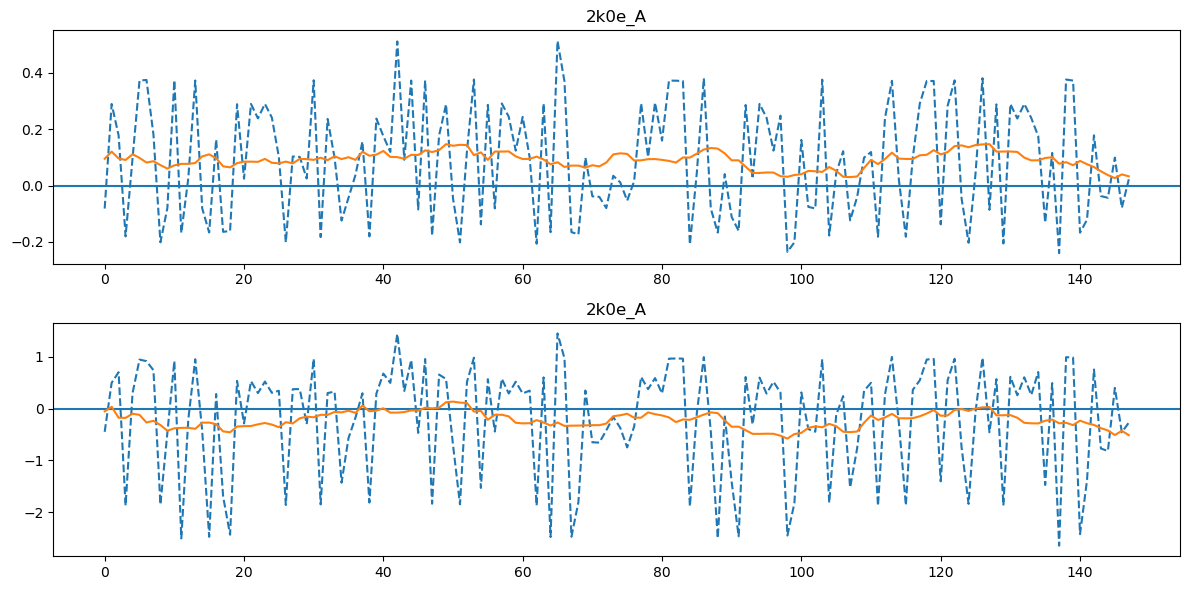

In [145]:
residues = [residue for residue in structure[0][chain] if residue.id[0] == " "]
seq = "".join([seq1(residue.get_resname()) for residue in residues])
pred, pred_smooth = iupred_M(seq)
fig, ax = plt.subplots(2,figsize=(12, 6))
ax[0].set_title("{}_{}".format(id_protein, chain))
ax[0].axhline()
ax[0].plot(np.arange(len(seq)), pred, ls='--')
ax[0].plot(np.arange(len(seq)), pred_smooth, ls='-')
pred, pred_smooth = iupred_P(seq)
ax[1].set_title("{}_{}".format(id_protein, chain))
ax[1].axhline()
ax[1].plot(np.arange(len(seq)), pred, ls='--')
ax[1].plot(np.arange(len(seq)), pred_smooth, ls='-')
plt.tight_layout()  # Remove figure padding
plt.savefig(path + '/figures_mid_term2/iupred_{}_{}.png'.format(id_protein, chain), dpi=300, bbox_inches='tight')


Calculate the estimated energy of each residue based on the weighted contribution of the
frequency of neighboring amino acids in the sequence and plot the raw and smoothed energy
for each residue on the same figure. Use the P matrix to calculate the estimated energy.
Neighboring residues are those 2-100 residues apart from the current position.
$$E_{i}^p = \sum_{j=1}^{20} M_{ij} c_{j}^p$$

Report the disorder content for the two different calculations. Disorder content can be calculated
as the fraction of residues with positive energy (≥ 0) over the length of the sequence. Please
report both the fraction and the raw count of residues with positive energy.

In [146]:
pred_M, pred_smooth_M = iupred_M(seq)
pred_P, pred_smooth_P = iupred_M(seq)


count_P=np.array(pred_P)

count_M = np.array(pred_M ) > 0
count=0 
for i in count_M:
    if i:
        count+=1

count



0 0 A 148 146 0 0 2 148
[10  0 16 21  8 11  1  8  8  9  9  6  2  6  6  4 12  7  0  2]
[0.06849315 0.         0.10958904 0.14383562 0.05479452 0.07534247
 0.00684932 0.05479452 0.05479452 0.06164384 0.06164384 0.04109589
 0.01369863 0.04109589 0.04109589 0.02739726 0.08219178 0.04794521
 0.         0.01369863]
[-0.01369863 -0.          0.01753425  0.03739726 -0.02520548 -0.01958904
  0.00342466 -0.03123288  0.00547945 -0.02219178 -0.01356164  0.00287671
  0.00191781  0.00041096  0.00821918 -0.00246575 -0.00410959 -0.02013699
  0.         -0.00684932]
0 A -0.08178082191780822
1 2 D 148 145 0 0 3 148
[10  0 16 21  8 11  1  8  8  9  9  6  2  5  6  4 12  7  0  2]
[0.06896552 0.         0.11034483 0.14482759 0.05517241 0.07586207
 0.00689655 0.05517241 0.05517241 0.06206897 0.06206897 0.04137931
 0.0137931  0.03448276 0.04137931 0.02758621 0.08275862 0.04827586
 0.         0.0137931 ]
[ 0.01103448  0.          0.01875862  0.07965517  0.02096552  0.02655172
 -0.00158621  0.02427586  0.0215172

94